# Test Set Evaluation: Baselines vs Fine-Tuned Cross-Encoder

This notebook evaluates our models on the **held-out test dataset** containing two unseen skills:
1.  `deep_q_learning`
2.  `model_deployment_api`

We will compare the performance of:
1.  **BM25** (Lexical Baseline)
2.  **SBERT Base** (Semantic Baseline - Bi-Encoder)
3.  **Cross-Encoder Zero-Shot** (Re-ranking Baseline)
4.  **Fine-Tuned Cross-Encoder** (Our Final Model)

**Methodology**:
*   For BM25 and SBERT, we rank the entire corpus.
*   For Cross-Encoders, we use SBERT to retrieve the top-100 candidates and then re-rank them.

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
import yaml
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
TEST_DATA_DIR = Path('../data/test_dataset')
MODEL_DIR = Path('../models')
CONFIG_PATH = Path('../config/skills_test.yml')

chunks_df = pd.read_csv(TEST_DATA_DIR / 'transcript_chunks.csv')

# Load VIDEO-LEVEL Ground Truth
video_labels_df = pd.read_csv(TEST_DATA_DIR / 'labeling/labeled_videos.csv')

#  calculate Quality Score (Weighted Sum)
def calculate_quality_score(row):
    """
    Calculate overall quality score combining multiple dimensions.

    """
    weights = {
        'traditional_relevance': 0.40,
        'depth': 0.25,
        'practical_examples': 0.20,
        'clarity': 0.10,
        'instructional_language': 0.05
    }

    quality_score = (
        weights['traditional_relevance'] * row['traditional_relevance'] +
        weights['depth'] * row['depth'] +
        weights['clarity'] * row['clarity'] +
        weights['practical_examples'] * row['practical_examples'] +
        weights['instructional_language'] * row['instructional_language']
    )
    return quality_score

print("Calculating Quality Scores...")
video_labels_df['quality_score'] = video_labels_df.apply(calculate_quality_score, axis=1)
print(f"Quality Score Range: {video_labels_df['quality_score'].min():.2f} - {video_labels_df['quality_score'].max():.2f}")

# Filter chunks to only those belonging to the labeled videos
# (We only evaluate on the set of videos we have ground truth for)
labeled_video_ids = video_labels_df['video_id'].unique()
test_chunks_df = chunks_df[chunks_df['video_id'].isin(labeled_video_ids)].copy()

print(f"Loaded {len(video_labels_df)} labeled videos.")
print(f"Loaded {len(test_chunks_df)} chunks for these videos.")

# Load Skills Config (Queries)
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

skills_map = {s['skill_id']: s for s in config['skills']}
print(f"Loaded skills: {list(skills_map.keys())}")

c:\Users\jaime\OneDrive\BU\1st Semester\Deep Learning\Deep Learning Project\Deep-Learning-Project\dl-project-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading test data...
Calculating Quality Scores...
Quality Score Range: 1.40 - 4.58
Loaded 138 labeled videos.
Loaded 2839 chunks for these videos.
Loaded skills: ['deep_q_learning', 'model_deployment_api']


## 2. BM25 Evaluation (Lexical Baseline)

In [ ]:

corpus = test_chunks_df['text'].tolist()
tokenized_corpus = [doc.lower().split() for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

def get_bm25_scores(query):
    tokenized_query = query.lower().split()
    scores = bm25.get_scores(tokenized_query)
    return scores

print("BM25 Index Built.")

BM25 Index Built.


## 3. SBERT Evaluation (Semantic Baseline)

We use `all-mpnet-base-v2` as our strong baseline Bi-Encoder.
We also generate **Skill Embeddings** by encoding the `"{name}. {description}"` string, as done in our training pipeline.

In [ ]:
# Check if predictions already exist to avoid unnecessary loading
predictions_save_path = TEST_DATA_DIR / 'test_set_predictions.csv'

if not predictions_save_path.exists():
    # Load SBERT Base Model
    SBERT_MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
    print(f"Loading SBERT model: {SBERT_MODEL_NAME}...")
    model_sbert = SentenceTransformer(SBERT_MODEL_NAME)

    # Encode Corpus (Test Chunks)
    corpus_embeddings = model_sbert.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

    # Generate Skill Embeddings
    print("Encoding skill descriptions...")
    skill_texts = [f"{s['name']}. {s['description']}" for s in skills_map.values()]
    skill_embeddings = model_sbert.encode(skill_texts, convert_to_tensor=True, show_progress_bar=True)

    print("SBERT Embeddings Ready.")
else:
    print("Predictions file found. Skipping SBERT model loading and encoding.")

Predictions file found. Skipping SBERT model loading and encoding.


## 4. Cross-Encoder Evaluation (Re-ranking)

We evaluate two Cross-Encoders:
1.  **Zero-Shot**: `cross-encoder/ms-marco-MiniLM-L-6-v2` (Pre-trained on MS MARCO)
2.  **Fine-Tuned**: Our custom model trained on the project dataset.

**Strategy**:
Since Cross-Encoders are computationally expensive, we use a **Retrieve & Re-rank** pipeline:
1.  **Retrieve**: Use SBERT to get the top-100 candidates for each query.
2.  **Re-rank**: Score these 100 candidates using the Cross-Encoder.

In [ ]:
if not predictions_save_path.exists():
    # Load Cross-Encoders
    CE_BASE_NAME = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
    CE_FT_PATH = '../models/best_model_fold0'  # Path to our fine-tuned model

    print(f"Loading Zero-Shot Cross-Encoder: {CE_BASE_NAME}...")
    ce_base = CrossEncoder(CE_BASE_NAME)

    print(f"Loading Fine-Tuned Cross-Encoder: {CE_FT_PATH}...")
    # Note: If this fails, ensure the path is correct and points to a compatible model
    try:
        ce_finetuned = CrossEncoder(CE_FT_PATH)
        print(" Fine-Tuned model loaded successfully.")
    except Exception as e:
        print(f"Error loading fine-tuned model: {e}")
        ce_finetuned = None
else:
    print("Predictions file found. Skipping Cross-Encoder model loading.")
    ce_base = None
    ce_finetuned = None

def rerank_with_ce(model, query, candidates):
    """
    Rerank candidates using a Cross-Encoder.
    candidates: List of (doc_text, original_index) tuples
    """
    if model is None:
        return []

    # Prepare pairs [Query, Doc]
    pairs = [[query, doc_text] for doc_text, _ in candidates]

    # Predict scores
    scores = model.predict(pairs, show_progress_bar=False)

    # Combine scores with original indices
    scored_candidates = []
    for i, score in enumerate(scores):
        original_idx = candidates[i][1]
        scored_candidates.append((score, original_idx))

    return scored_candidates

Predictions file found. Skipping Cross-Encoder model loading.


## 5. Evaluation Loop (NDCG & MRR)

In [ ]:
from typing import List, Dict
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest



def clean_text(text):
    """Simple text cleaning for BM25 query"""
    return text.lower().split()


def rank_videos_sbert(
    skill_embedding: np.ndarray,
    chunk_embeddings: np.ndarray,
    chunks_df: pd.DataFrame,
    aggregation: str = 'mean_topk',
    top_k_chunks: int = 5
):
    """
    Rank videos using SBERT cosine similarity.
    """
    top_k_chunks = max(1, int(top_k_chunks))

    # Compute cosine similarity between skill and all chunks
    # Reshape skill_embedding to 2D for sklearn
    similarities = cosine_similarity(
        skill_embedding.reshape(1, -1),
        chunk_embeddings
    )[0]  # Extract 1D array

    # Add similarities to chunks
    chunks_with_scores = chunks_df.copy()
    chunks_with_scores['score'] = similarities

    # Aggregate to video level
    if aggregation == 'mean_topk':
        # Take mean of top-k chunk similarities per video
        def mean_topk(group):
            top_scores = group['score'].nlargest(min(top_k_chunks, len(group)))
            return top_scores.mean()
        video_scores = (
            chunks_with_scores.groupby('video_id')
            .apply(mean_topk)
            .reset_index(name='score')
        )
    else:
        raise ValueError(f"Unknown aggregation: {aggregation}")

    return video_scores

def precision_at_k(ranked_items: List[str], relevant_items: set, k: int) -> float:
    """
    Calculate Precision@K.
    Precision@K = (# relevant items in top-K) / K
    """
    if k == 0 or len(ranked_items) == 0:
        return 0.0

    top_k = ranked_items[:k]
    relevant_in_top_k = sum(1 for item in top_k if item in relevant_items)
    return relevant_in_top_k / k


def dcg_at_k(ranked_items: List[str], relevance_scores: Dict[str, float], k: int) -> float:
    """
    Calculate Discounted Cumulative Gain at K.
    DCG@K = sum(rel_i / log2(i + 1)) for i in 1..K
    """
    dcg = 0.0
    for i, item in enumerate(ranked_items[:k], start=1):
        rel = relevance_scores.get(item, 0)
        dcg += rel / np.log2(i + 1)
    return dcg


def ndcg_at_k(ranked_items: List[str], relevance_scores: Dict[str, float], k: int) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain at K.
    NDCG@K = DCG@K / IDCG@K
    """
    dcg = dcg_at_k(ranked_items, relevance_scores, k)

    # Calculate ideal DCG@K
    ideal_ranking = sorted(relevance_scores.keys(), key=lambda x: relevance_scores[x], reverse=True)
    idcg = dcg_at_k(ideal_ranking, relevance_scores, k)

    if idcg == 0:
        return 0.0

    return dcg / idcg

def calculate_metrics(video_scores_df, true_relevance_df, k=10, score_col='quality_score', threshold=3.0):
    """
    Calculate NDCG@k and Precision@k for VIDEO rankings using custom metrics.

    Args:
        video_scores_df: DataFrame with 'video_id' and 'score' (predicted)
        true_relevance_df: DataFrame with 'video_id' and ground truth columns
        k: Top-k for evaluation
        score_col: Column name in true_relevance_df to use as the relevance score (e.g., 'quality_score' or 'traditional_relevance')
        threshold: Threshold for binary relevance (Precision@K)
    """
    # Merge predicted scores with ground truth to ensure we only rank videos we have labels for
    merged = pd.merge(video_scores_df, true_relevance_df, on='video_id', how='inner')

    if len(merged) == 0:
        return 0.0, 0.0

    # Sort by predicted score descending to get ranking
    ranked_videos = merged.sort_values('score', ascending=False)['video_id'].tolist()

    # Prepare ground truth dictionaries/sets
    relevance_scores = dict(zip(merged['video_id'], merged[score_col]))
    relevant_videos = set(merged[merged[score_col] >= threshold]['video_id'])

    # Calculate metrics
    ndcg = ndcg_at_k(ranked_videos, relevance_scores, k)
    precision = precision_at_k(ranked_videos, relevant_videos, k)

    return ndcg, precision

def aggregate_top_k(group, k=5):
    """
    Aggregates chunk scores to a video score using the mean of the top-k chunks.
    Used for BM25 and Cross-Encoders to match SBERT logic.
    """
    return group.nlargest(k, 'score')['score'].mean()


In [ ]:
predictions_save_path = TEST_DATA_DIR / 'test_set_predictions.csv'

if predictions_save_path.exists():
    print(f"Loading saved predictions from {predictions_save_path}...")
    predictions_df = pd.read_csv(predictions_save_path)
    print(f"Loaded {len(predictions_df)} rows.")
else:
    print("Generating predictions for all models...")
    all_predictions = []


    chunk_embeddings_np = corpus_embeddings.cpu().numpy()

    for skill_id, skill_info in skills_map.items():
        print(f"Processing Skill: {skill_info['name']}")

        # 1. Get Chunks for this skill's videos
        skill_labels = video_labels_df[video_labels_df['skill_id'] == skill_id]
        if len(skill_labels) == 0:
            continue

        target_video_ids = skill_labels['video_id'].unique()
        skill_chunks_mask = test_chunks_df['video_id'].isin(target_video_ids)
        skill_chunks = test_chunks_df[skill_chunks_mask].copy()

        # Map indices back to original corpus for SBERT/BM25 indexing
        corpus_indices = [test_chunks_df.index.get_loc(idx) for idx in skill_chunks.index]

        # 1. Encode Skill Description
        skill_query_text = f"{skill_info['name']}. {skill_info['description']}"
        skill_emb = model_sbert.encode(skill_query_text, convert_to_numpy=True)


        # We extract the relevant chunk embeddings
        relevant_chunk_embeddings = chunk_embeddings_np[corpus_indices]

        # Compute cosine similarity
        sbert_scores = cosine_similarity(skill_emb.reshape(1, -1), relevant_chunk_embeddings)[0]
        skill_chunks['score_sbert_skill'] = sbert_scores

        # --- Cross-Encoder ---
        # Calculated once per skill using the description, not the query
        pairs_desc = [[skill_query_text, text] for text in skill_chunks['text']]

        # Zero-Shot
        skill_chunks['score_ce_base'] = ce_base.predict(pairs_desc, show_progress_bar=False)

        # Fine-Tuned
        if ce_finetuned:
            skill_chunks['score_ce_ft'] = ce_finetuned.predict(pairs_desc, show_progress_bar=False)
        else:
            skill_chunks['score_ce_ft'] = 0.0

        for query in skill_info['queries']:
            # Create a copy for this query to store query-specific scores
            query_chunks = skill_chunks.copy()
            query_chunks['query'] = query
            query_chunks['skill_id'] = skill_id

            # --- BM25 ---

            bm25_all_scores = get_bm25_scores(query)
            query_chunks['score_bm25'] = [bm25_all_scores[i] for i in corpus_indices]

            all_predictions.append(query_chunks)

    predictions_df = pd.concat(all_predictions, ignore_index=True)
    print(f"Generated predictions for {len(predictions_df)} query-chunk pairs.")

Loading saved predictions from ..\data\test_dataset\test_set_predictions.csv...
Loaded 14195 rows.


In [ ]:

predictions_save_path = TEST_DATA_DIR / 'test_set_predictions.csv'
predictions_df.to_csv(predictions_save_path, index=False)
print(f"Predictions saved to {predictions_save_path}")

Predictions saved to ..\data\test_dataset\test_set_predictions.csv


In [ ]:
results = []

# Define metrics to evaluate
METRICS_CONFIG = [
    {'col': 'quality_score', 'threshold': 3.5, 'label': 'Quality'},
    {'col': 'traditional_relevance', 'threshold': 4.0, 'label': 'Relevance'}
]

print(f"Evaluating on: {[m['label'] for m in METRICS_CONFIG]}")

for skill_id, skill_info in skills_map.items():
    print(f"\nEvaluating Skill: {skill_info['name']}")

    cols_to_keep = ['video_id'] + [m['col'] for m in METRICS_CONFIG]
    skill_labels = video_labels_df[video_labels_df['skill_id'] == skill_id][cols_to_keep]

    if len(skill_labels) == 0:
        continue

    # Get predictions for this skill
    skill_preds = predictions_df[predictions_df['skill_id'] == skill_id]

    # We take the first query's subset just to get the unique chunks/videos once.
    first_query = skill_info['queries'][0]
    first_query_preds = skill_preds[skill_preds['query'] == first_query]

    # Pre-calculate aggregated scores for description models
    video_scores_sbert_skill = first_query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_sbert_skill': 'score'}))).reset_index(name='score')
    video_scores_ce_base = first_query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_ce_base': 'score'}))).reset_index(name='score')
    video_scores_ce_ft = first_query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_ce_ft': 'score'}))).reset_index(name='score')

    for query in skill_info['queries']:
        query_preds = skill_preds[skill_preds['query'] == query]

        # Pre-calculate aggregated scores for query models (BM25)
        video_scores_bm25 = query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_bm25': 'score'}))).reset_index(name='score')

        row_result = {'skill': skill_id, 'query': query}

        # Loop through metric configurations (Quality vs Relevance)
        for cfg in METRICS_CONFIG:
            col = cfg['col']
            thresh = cfg['threshold']
            lbl = cfg['label']

            # Calculate metrics for each model
            ndcg_sbert, prec_sbert = calculate_metrics(video_scores_sbert_skill, skill_labels, score_col=col, threshold=thresh)
            ndcg_ce_base, prec_ce_base = calculate_metrics(video_scores_ce_base, skill_labels, score_col=col, threshold=thresh)
            ndcg_ce_ft, prec_ce_ft = calculate_metrics(video_scores_ce_ft, skill_labels, score_col=col, threshold=thresh)
            ndcg_bm25, prec_bm25 = calculate_metrics(video_scores_bm25, skill_labels, score_col=col, threshold=thresh)

            # Store with label suffix
            row_result[f'NDCG@10_BM25_{lbl}'] = ndcg_bm25
            row_result[f'NDCG@10_SBERT_SkillDesc_{lbl}'] = ndcg_sbert
            row_result[f'NDCG@10_CE_ZeroShot_Desc_{lbl}'] = ndcg_ce_base
            row_result[f'NDCG@10_CE_FineTuned_Desc_{lbl}'] = ndcg_ce_ft

            row_result[f'Precision@10_BM25_{lbl}'] = prec_bm25
            row_result[f'Precision@10_SBERT_SkillDesc_{lbl}'] = prec_sbert
            row_result[f'Precision@10_CE_ZeroShot_Desc_{lbl}'] = prec_ce_base
            row_result[f'Precision@10_CE_FineTuned_Desc_{lbl}'] = prec_ce_ft

        results.append(row_result)

results_df = pd.DataFrame(results)
print("\nEvaluation Complete.")

Evaluating on: ['Quality', 'Relevance']

Evaluating Skill: Deep Q-Learning Implementation


C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_sbert_skill = first_query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_sbert_skill': 'score'}))).reset_index(name='score')
C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_ce_ba


Evaluating Skill: Model Deployment with FastAPI/Flask


C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_ce_base = first_query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_ce_base': 'score'}))).reset_index(name='score')
C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_ce_ft = first


Evaluation Complete.


C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_bm25 = query_preds.groupby('video_id').apply(lambda x: aggregate_top_k(x.rename(columns={'score_bm25': 'score'}))).reset_index(name='score')
C:\Users\jaime\AppData\Local\Temp\ipykernel_15540\3963023249.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  video_scores_bm25 = query_preds.groupb

## 6. Results Analysis

TEST SET MODEL COMPARISON (QUALITY)
                     model  precision_at_10  ndcg_at_10
                      BM25             0.59    0.814945
                     SBERT             0.75    0.861287
 Cross-Encoder (Zero-Shot)             0.55    0.852095
Cross-Encoder (Fine-Tuned)             0.95    0.929493


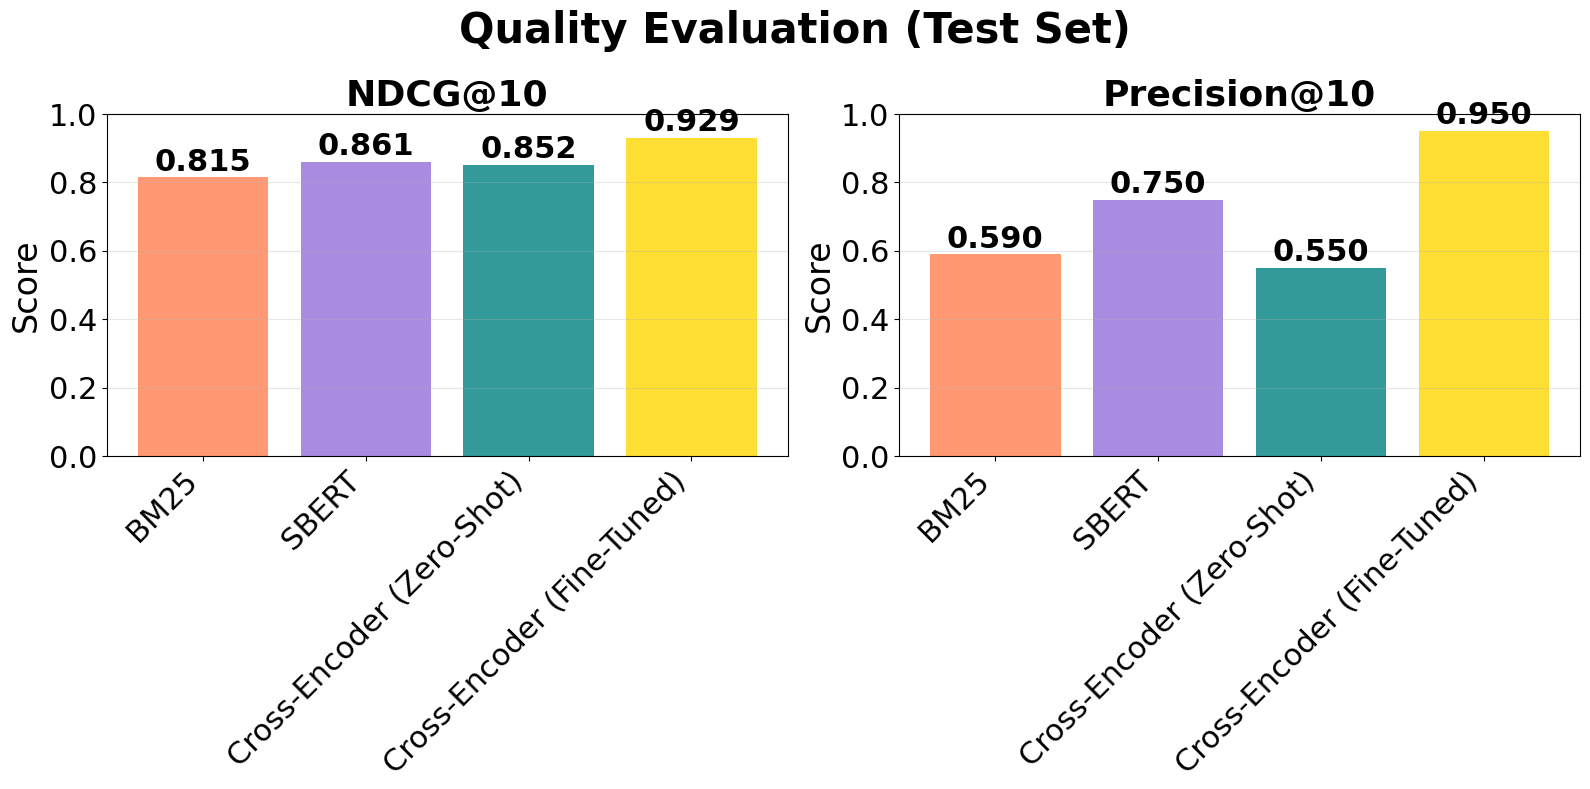

TEST SET MODEL COMPARISON (RELEVANCE)
                     model  precision_at_10  ndcg_at_10
                      BM25             0.64    0.804376
                     SBERT             0.75    0.852249
 Cross-Encoder (Zero-Shot)             0.55    0.845442
Cross-Encoder (Fine-Tuned)             0.95    0.944591


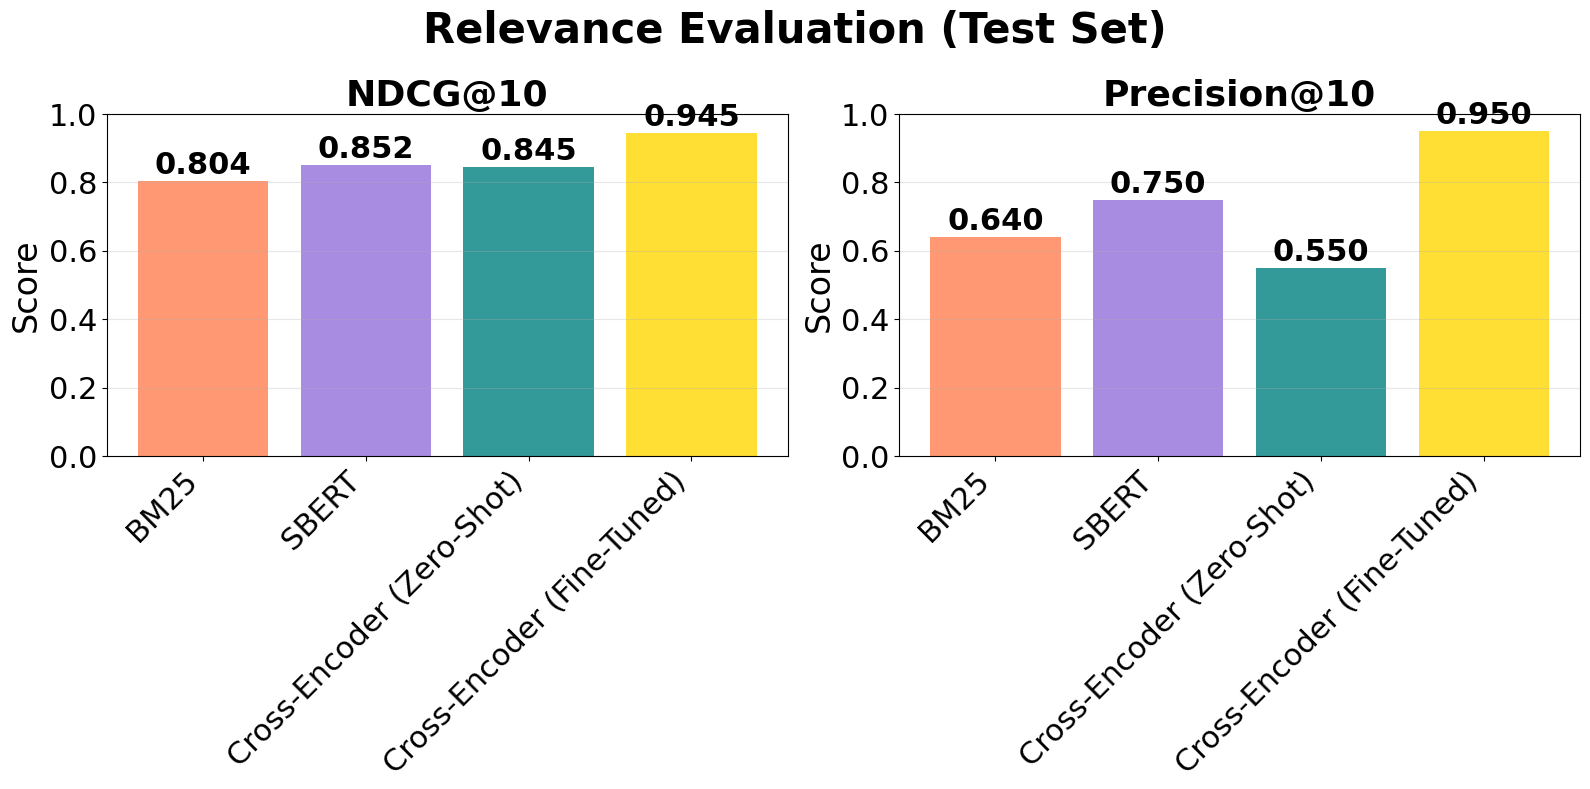

Detailed results saved to ..\data\test_dataset\evaluation_results_full.csv


In [ ]:
# Calculate Average Metrics across all skills/queries
avg_metrics = results_df.mean(numeric_only=True)

def plot_metrics(metric_label, save_suffix):
    # Construct Comparison DataFrame for this metric
    comparison_records = [
        {'model': 'BM25',
         'precision_at_10': avg_metrics[f'Precision@10_BM25_{metric_label}'],
         'ndcg_at_10': avg_metrics[f'NDCG@10_BM25_{metric_label}']},
        {'model': 'SBERT',
         'precision_at_10': avg_metrics[f'Precision@10_SBERT_SkillDesc_{metric_label}'],
         'ndcg_at_10': avg_metrics[f'NDCG@10_SBERT_SkillDesc_{metric_label}']},
        {'model': 'Cross-Encoder (Zero-Shot)',
         'precision_at_10': avg_metrics[f'Precision@10_CE_ZeroShot_Desc_{metric_label}'],
         'ndcg_at_10': avg_metrics[f'NDCG@10_CE_ZeroShot_Desc_{metric_label}']},
        {'model': 'Cross-Encoder (Fine-Tuned)',
         'precision_at_10': avg_metrics[f'Precision@10_CE_FineTuned_Desc_{metric_label}'],
         'ndcg_at_10': avg_metrics[f'NDCG@10_CE_FineTuned_Desc_{metric_label}']},
    ]

    comparison_df = pd.DataFrame(comparison_records)

    print("="*80)
    print(f"TEST SET MODEL COMPARISON ({metric_label.upper()})")
    print("="*80)
    print(comparison_df.to_string(index=False))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'{metric_label} Evaluation (Test Set)', fontsize=30, fontweight='bold')
    colors = ['coral', 'mediumpurple', 'teal', 'gold']

    # Plot NDCG@10
    x_pos = range(len(comparison_df))
    axes[0].bar(x_pos, comparison_df['ndcg_at_10'], color=colors, alpha=0.8)
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(comparison_df['model'], rotation=45, ha='right', fontsize=22)
    axes[0].set_title('NDCG@10', fontsize=26, fontweight='bold')
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('Score', fontsize=24)
    axes[0].tick_params(axis='y', labelsize=22)
    axes[0].grid(axis='y', alpha=0.3)

    for i, v in enumerate(comparison_df['ndcg_at_10']):
        axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold', fontsize=22)

    # Plot Precision@10
    axes[1].bar(x_pos, comparison_df['precision_at_10'], color=colors, alpha=0.8)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(comparison_df['model'], rotation=45, ha='right', fontsize=22)
    axes[1].set_title('Precision@10', fontsize=26, fontweight='bold')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Score', fontsize=24)
    axes[1].tick_params(axis='y', labelsize=22)
    axes[1].grid(axis='y', alpha=0.3)

    for i, v in enumerate(comparison_df['precision_at_10']):
        axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold', fontsize=22)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    comparison_df.to_csv(TEST_DATA_DIR / f'model_comparison_summary_{save_suffix}.csv', index=False)

# Plot for Quality
plot_metrics('Quality', 'quality')

# Plot for Relevance
plot_metrics('Relevance', 'relevance')

# Save Full Results
results_df.to_csv(TEST_DATA_DIR / 'evaluation_results_full.csv', index=False)
print(f"Detailed results saved to {TEST_DATA_DIR / 'evaluation_results_full.csv'}")